In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

#### 훈련세트와 테스트세트 CSV파일을 pandas로 읽어와 dataframe 만들기

In [ ]:
# /kaggle/input/titanic/train.csv
# /kaggle/input/titanic/test.csv
# /kaggle/input/titanic/gender_submission.csv

train = pd.read_csv("/kaggle/input/titanic/train.csv")
train.head()

In [ ]:
test = pd.read_csv("/kaggle/input/titanic/test.csv")
test.head()

### **Data Analysis**

#### feature에 따른 생존여부를 막대그래프로 시각화하는 함수를 구현해보자.

In [ ]:
import matplotlib.pyplot as plt

def bar_chart(feature):
    survived = train[train['Survived']==1][feature].value_counts()
    dead = train[train['Survived']==0][feature].value_counts()
    df = pd.DataFrame([survived, dead])
    df.index = ['Survived', 'Dead']
    df.plot(kind='bar', stacked=True, figsize=(10,5))    

#### **feature1: Sex (성별)**

In [ ]:
bar_chart('Sex')

- #### 남성의 사망비율이 여성의 사망비율보다 압도적으로 높다는 것을 확인할 수 있다.

#### **feature2: Pclass (객실 등급)**

In [ ]:
bar_chart('Pclass')

- #### 객실 등급이 낮을수록 사망비율이 높아지는 것을 확인할 수 있다.

#### **feature3: SibSp (형제자매/배우자)**

In [ ]:
bar_chart('SibSp')

- #### 형제자매 또는 배우자와 함께 탑승한 경우, 혼자 탑승했을 때보다 살 확률이 높았다. 

#### **feature4: Parch (부모/자식)**

In [ ]:
bar_chart('Parch')

- #### 부모 또는 자식과 함께 탑승한 경우, 혼자 탑승했을 때보다 살 확률이 높았다.

#### **feature5: Embarked (탑승 항구)**

In [ ]:
bar_chart('Embarked')

- #### 탑승항구가 S 또는 Q 였을 경우 사망확률이 높았다.
- #### 탑승항구가 C 였을 경우 생존확률이 높았다.

### **Feature Engineering**

#### **문자로 이루어진 데이터는 추후 모델링을 위해 수치로 변환해주고,**
#### **결측치가 있다면 통계학적인 방법으로 채워넣자.**

#### **feature6: Name (이름)**

- #### 이름 자체보다는 이름 앞에 붙는 '호칭'이 중요한 정보가 될 수 있다. 
- #### train세트와 test세트에 들어있는 호칭만 추출하여 'Title'이란 데이터세트로 만들어 보자.

In [ ]:
train_test_data = [train, test] #훈련세트와 테스트세트의 결합 

for dataset in train_test_data:
    dataset['Title'] = dataset['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    
#띄어쓰기로 시작해 모든 알파벳이 포함된 문자열을 한 번이상 반복하다가 dot(.)으로 마무리하는 문자열 추출 
#Mr,Miss 등 영어 호칭이 추출된다.

In [ ]:
train['Title'].value_counts()

In [ ]:
test['Title'].value_counts()

- #### 호칭이 생각보다 많고 다양하다 
- #### 가장 빈도가 많은 Mr, Miss, Mrs, Master 만 구분하고 나머지는 Others로 구분하자.
- #### 추후 modeling을 위해 호칭을 수치로 mapping 해 놓자.

In [ ]:
#Mr:0, Miss:1, Mrs:2, Master:3, Others:4

title_mapping = {'Mr':0, 'Miss':1, 'Mrs':2, 'Master':3, 'Dr':4, 'Rev':4, 'Mlle':4, 'Major':4, 'Col':4, 'Countess':4, 'Capt':4, 'Ms':4, 'Sir':4, 'Lady':4, 'Mme':4, 'Don':4, 'Jonkheer':4, 'Dona':4}

for dataset in train_test_data:
    dataset['Title'] = dataset['Title'].map(title_mapping)

In [ ]:
train.head()

In [ ]:
test.head()

In [ ]:
bar_chart('Title')

- #### Mr.는 사망확률이 매우 높게 나타난다.
- #### 그 외는 상대적으로 생존 확률이 높다.

- #### 이제 'Name' feature은 필요없으므로, 데이터세트에서 지우자. 'Title' feature 가 이를 대체해줄 것이다.

In [ ]:
train.drop('Name', axis=1, inplace=True)
test.drop('Name', axis=1, inplace=True)

In [ ]:
train.head()

In [ ]:
test.head()

#### **'Sex' feature의 수치화**

In [ ]:
#male: 0, female: 1

sex_mapping = {'male':0, 'female':1}
for dataset in train_test_data:
    dataset['Sex'] = dataset['Sex'].map(sex_mapping)

In [ ]:
bar_chart('Sex')

#### **결측치 탐색**

In [ ]:
train.info()

In [ ]:
train.isnull().sum()

In [ ]:
test.info()

In [ ]:
test.isnull().sum()

#### Age, Embarked, Fare, Cabin feature 에서 결측치가 확인되었다.

#### **feature7: Age (나이)**

#### **'Age' feature의 결측치를 'Title'의 group별로(Mr, Mrs, Miss, Master, others) 중앙값을 취하여 채워주자.**

In [ ]:
train['Age'].fillna(train.groupby('Title')['Age'].transform('median'), inplace=True)
test['Age'].fillna(test.groupby('Title')['Age'].transform('median'), inplace=True)

#### seaborn을 이용하여 데이터 분포를 시각화 해보자

In [ ]:
import seaborn as sns

facet = sns.FacetGrid(train, hue='Survived', aspect=4)
facet.map(sns.kdeplot,'Age',shade=True)
facet.set(xlim=(0, train['Age'].max()))
facet.add_legend()

plt.show()

#### 그래프 분포가 비슷한 나이대로 구간을 나눠서 자세히 살펴보자 

In [ ]:
facet = sns.FacetGrid(train, hue='Survived', aspect=4)
facet.map(sns.kdeplot,'Age',shade=True)
facet.set(xlim=(0, train['Age'].max()))
facet.add_legend()
plt.xlim(0,20) #0~20살 까지


In [ ]:
facet = sns.FacetGrid(train, hue='Survived', aspect=4)
facet.map(sns.kdeplot,'Age',shade=True)
facet.set(xlim=(0, train['Age'].max()))
facet.add_legend()
plt.xlim(20,30) #20~30살 까지


In [ ]:
facet = sns.FacetGrid(train, hue='Survived', aspect=4)
facet.map(sns.kdeplot,'Age',shade=True)
facet.set(xlim=(0, train['Age'].max()))
facet.add_legend()
plt.xlim(30,35) #30~35살 까지

In [ ]:
facet = sns.FacetGrid(train, hue='Survived', aspect=4)
facet.map(sns.kdeplot,'Age',shade=True)
facet.set(xlim=(0, train['Age'].max()))
facet.add_legend()
plt.xlim(36,60) #30~60살 까지

#### Binning 작업 - 나이대 별로 그룹을 묶어주자 

In [ ]:
def age_binning(data): 
    if int(data) <= 20 :
        return '0'
    elif (int(data)>20) and (int(data)<=30):
        return '1'
    elif (int(data)>30) and (int(data)<=35):
        return '2'
    elif (int(data)>35) and (int(data)<=60):
        return '3'
    elif int(data)>60:
        return '4'

for dataset in train_test_data:
    dataset['Age'] = dataset['Age'].apply(age_binning) 

train.head()

In [ ]:
train.head()

In [ ]:
bar_chart('Age')

- #### 특히 20대의 사망비율이 높게 나타난다.

#### **'Embarked' feature 결측치 채우기 및 수치화 과정**

#### **'탑승 항구'는 '객실 등급'과 연관성이 있을 것으로 추측하였다.**
#### **Pclass에 따른 탑승 항구를 알아보자.**

In [ ]:
Pclass1 = train[train['Pclass']==1]['Embarked'].value_counts()
Pclass2 = train[train['Pclass']==2]['Embarked'].value_counts()
Pclass3 = train[train['Pclass']==3]['Embarked'].value_counts()
df = pd.DataFrame([Pclass1, Pclass2, Pclass3])
df.index = ['1st class', '2nd class', '3rd class']
df.plot(kind='bar', stacked=True, figsize=(10,5))

- #### 'Q'항구는 대부분 3rd class 가 이용하였다. 
- #### 모든 Pclass에서 'S'항구를 이용하는 사람이 과반수였다. 

- #### Pclass와 상관 없이 결측치를 확률상 'S'로 채워도 무방할 것이다.

In [ ]:
for dataset in train_test_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')

In [ ]:
train.head(10)

#### 추후 모델링을 위해 mapping으로 수치화를 해놓자.

In [ ]:
embarked_mapping = {'S':0, 'C':1, 'Q':2}
for dataset in train_test_data:
    dataset['Embarked'] = dataset['Embarked'].map(embarked_mapping)

In [ ]:
train.head(10)

#### **feature8: Fare (요금)**

#### **객실 등급(Pclass)을 그룹화하여 각 그룹 'Fare'의 중앙값을 'Fare' feature의 결측치로 채워넣자.**

In [ ]:
train['Fare'].fillna(train.groupby('Pclass')['Fare'].transform('median'), inplace=True)
test['Fare'].fillna(train.groupby('Pclass')['Fare'].transform('median'), inplace=True)

#### seaborn을 활용하여 데이터 분포를 수치화 해보자.

In [ ]:
import seaborn as sns

facet = sns.FacetGrid(train, hue='Survived', aspect=4)
facet.map(sns.kdeplot, 'Fare', shade=True)
facet.set(xlim=(0, train['Fare'].max()))
facet.add_legend()

plt.show()

#### (0,100) 구간을 더 자세히 들여다 보자.

In [ ]:
facet = sns.FacetGrid(train, hue='Survived', aspect=4)
facet.map(sns.kdeplot, 'Fare', shade=True)
facet.set(xlim=(0, train['Fare'].max()))
facet.add_legend()
plt.xlim(0,100)

#### 그래프 특성이 비슷한 구간별로 나누어서 binning을 해보자. 

In [ ]:
def Fare_binning(data): 
    if int(data) <= 10 :
        return '0'
    elif (int(data)>10) and (int(data)<=30):
        return '1'
    elif (int(data)>30) and (int(data)<=100):
        return '2'
    elif int(data)>100:
        return '3'

for dataset in train_test_data:
    dataset['Fare'] = dataset['Fare'].apply(Fare_binning) 

train.head()

#### **feature9: Cabin (객실 구역)**

In [ ]:
train.Cabin.value_counts()

#### 객실 종류가 매우 다양하다. 첫번째 문자만을 가지고 Pclass에 대응하는 객실을 분석해 보자.

In [ ]:
for dataset in train_test_data:
    dataset['Cabin'] = dataset['Cabin'].str[:1]
    
Pclass1 = train[train['Pclass']==1]['Cabin'].value_counts()
Pclass2 = train[train['Pclass']==2]['Cabin'].value_counts()
Pclass3 = train[train['Pclass']==3]['Cabin'].value_counts()
df = pd.DataFrame([Pclass1, Pclass2, Pclass3])
df.index = ['1st class', '2nd class', '3rd class']
df.plot(kind='bar', stacked=True, figsize=(10,5))

- #### A-G 알파벳 순으로 객실구역에 따른 Pclass 등급이 낮아짐을 알 수 있다. 

#### Mapping으로 각 객실 구역을 수치로 바꿔주자.
#### feature scaling을 고려하여 범위를 적절히 설정해주자. 

In [ ]:
cabin_mapping = {'A':0, 'B':0.4, 'C':0.8, 'D':1.2, 'E':1.6, 'F':2, 'G':2.4, 'T':2.8}
for dataset in train_test_data:
    dataset['Cabin'] = dataset['Cabin'].map(cabin_mapping)

#### **객실등급(Pclass)을 그룹화하여 각 그룹에 해당하는 'Cabin'의 중앙값을 'Cabin' feature의 결측치로 채워넣자.**

In [ ]:
train['Cabin'].fillna(train.groupby('Pclass')['Cabin'].transform('median'), inplace=True)
test['Cabin'].fillna(train.groupby('Pclass')['Cabin'].transform('median'), inplace=True)

train.head()

#### New feature: FamilySize (가족 크기)

#### SibSp(형제/자매), Parch(부모/자식)의 수를 합친 FamilySize(총 가족의 수)를 새로운 특성으로 추출해보자. 
#### 가족이 정확히 누구였는지 보다 '가족의 유무'가 더 유용한 데이터가 될 것이다.

In [ ]:
train['FamilySize'] = train['SibSp'] + train['Parch'] + 1
test['FamilySize'] = test['SibSp'] + test['Parch'] + 1

facet = sns.FacetGrid(train, hue='Survived', aspect=4)
facet.map(sns.kdeplot, 'FamilySize', shade=True)
facet.set(xlim=(0, train['FamilySize'].max()))
facet.add_legend()
plt.xlim(0)

- #### 혼자 탔을 때 상당히 많은 경우 죽었다.
- #### 가족이 한 명이라도 있으면 살 수 있는 확률이 높아진다.

#### Mapping으로 각 'FamilySize'을 수치로 바꿔주자.
#### feature scaling을 고려하여 범위를 적절히 설정해주자. 

In [ ]:
family_mapping = {1: 0, 2: 0.4, 3: 0.8, 4: 1.2, 5: 1.6, 6: 2, 7: 2.4, 8: 2.8, 9: 3.2, 10: 3.6, 11: 4}
for dataset in train_test_data:
    dataset['FamilySize'] = dataset['FamilySize'].map(family_mapping)

train.head()

#### **이제 'SibSp'과 'Parch' features는 필요가 없으므로 데이터프레임에서 drop 시키겠다.**
#### **Ticket명도 생존여부와 관련이 없으므로 drop 시켜도 무방하다.** 
#### **PassengerId도 모델링 할 때는 필요가 없으므로 따로 drop 시켜도 무방하다.**

In [ ]:
features_drop = ['Ticket', 'SibSp', 'Parch', 'Cabin'] 
train = train.drop(features_drop, axis=1)
test = test.drop(features_drop, axis=1)
train = train.drop(['PassengerId'], axis=1)
test_data = test.drop(['PassengerId'], axis=1).copy()

#### **지도 학습을 하는 분류 모델을 훈련시키기 위해 train_data세트와 target데이터를 나누자.**

In [ ]:
train_data = train.drop('Survived', axis=1)
target = train['Survived']

train_data.shape, target.shape

In [ ]:
train_data.head()

In [ ]:
target.head()

In [ ]:
train_data.isnull().sum() #결측치도 이제 없다는 것을 확인하였다.

In [ ]:
test.head()

In [ ]:
train_data.head()

### **Data Normalization**

#### MinMax 정규화

In [ ]:
def minmax_norm(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = int(df[feature_name].max())
        min_value = int(df[feature_name].min())
        result[feature_name] = (pd.to_numeric(df[feature_name]) - min_value) / (max_value - min_value)
    return result

df_minmax_norm_train = minmax_norm(train_data)
df_minmax_norm_train

In [ ]:
df_minmax_norm_test = minmax_norm(test_data)
df_minmax_norm_test

#### StandardScaler 표준화

In [ ]:
from sklearn.preprocessing import StandardScaler #데이터 정규화 
ss = StandardScaler()
ss.fit(train_data)

train_scaled = ss.transform(train_data)
test_scaled = ss.transform(test_data)  #훈련 세트로 학습한 변환기를 사용해 테스트 세트까지 변환!

train_scaled_df = pd.DataFrame(train_scaled) 
test_scaled_df = pd.DataFrame(test_scaled)

train_scaled_df.columns = list(train_data) #열 제목 변경 
test_scaled_df.columns = list(test_data)

print(train_scaled_df)
print(test_scaled_df)

### **Modeling**

#### Classification Algorithms (분류 알고리즘)

- K-Nearest Neighbor (K-NN)
- Decision Tree
- Random Forest
- Naive Bayes Classifier
- Support Vector Machine (SVM)
- Logistic Regression
- Gradient Boosting Tree (GBT)
- SGD Classifier
- AdaBoost
- XGBClassifier
- HistGradientBoostingClassifier
- LGBMClassifier

#### Classifier 모듈을 import 해보자.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from lightgbm import LGBMClassifier

#### 훈련데이터의 과대적합을 막기 위해, 
#### 그리고 테스트데이터는 훈련에 사용할 수가 없으므로 Cross Validation (K-fold) 교차검증을 활용한다.

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
k_fold = KFold(n_splits=10, shuffle=True, random_state=0) #10개 구간으로 나누기 

#### for문을 활용하여 각 모델별로 교차 검증을 수행하고, 평균 및 표준편차를 계산한 후, 데이터프레임으로 만들어 보았다. 

In [ ]:
mod = [KNeighborsClassifier, DecisionTreeClassifier, RandomForestClassifier, GaussianNB, SVC, LogisticRegression, GradientBoostingClassifier, SGDClassifier, AdaBoostClassifier, HistGradientBoostingClassifier]
mod_ = ['KNeighborsClassifier', 'DecisionTreeClassifier', 'RandomForestClassifier', 'GaussianNB', 'SVC', 'LogisticRegression', 'GradientBoostingClassifier', 'SGDClassifier', 'AdaBoostClassifier', 'HistGradientBoostingClassifier',]
score_mean = []
score_std = []

for model in mod:
    clf = model()
    scoring = 'accuracy'
    score = cross_val_score(clf, train_scaled_df, target, cv=k_fold, n_jobs=-1, scoring=scoring)

    score_mean.append(round(np.mean(score)*100, 2))
    score_std.append(round(np.std(score), 2))

    
acc = pd.DataFrame({'Models':mod_,'Score_mean':score_mean, 'Score_std':score_std})
acc

#### Score_mean 기준으로 내림차순으로 정리해보자.

In [ ]:
acc.sort_values('Score_mean', ascending=False)

### **Hyper-Parameter Tuning**

#### 결정 트리 기반의 앙상블 학습은 강력하고 뛰어난 성능을 제공한다.
#### 위 교차검증에서도 최상위 결과를 가져온 GradientBoostingClassifier을 택하여 하이퍼파라미터 튜닝을 해보자.

### **GradientBoostingClassifier 튜닝**

#### GridSearch를 이용해 보자.

In [ ]:
from sklearn.model_selection import GridSearchCV
params = {'min_impurity_decrease' : [0.0001],
          'max_depth' : [3, 4, 5, 6, 7, 8],
          'min_samples_split' : [2, 12, 22, 32, 42, 52]
         }
gs = GridSearchCV(GradientBoostingClassifier(random_state=42), params, n_jobs=-1)

gs.fit(train_scaled_df, target)
dt = gs.best_estimator_
print(dt.score(train_scaled_df, target))
print(gs.best_params_)

#### 시간이 너무 오래 걸린다. 
#### Random Search를 사용해 보자. 

In [ ]:
from scipy.stats import uniform, randint

params = {'min_impurity_decrease' : uniform(0.0001, 0.001),
          'max_depth' : randint(3, 50),
          'min_samples_split' : randint(2, 25),
          'min_samples_leaf' : randint(1, 25)
         }

from sklearn.model_selection import RandomizedSearchCV
gs = RandomizedSearchCV(GradientBoostingClassifier(random_state=42), params, n_iter=100, n_jobs=-1, random_state=42)
gs.fit(train_scaled_df, target)
print(gs.best_params_)

GB = gs.best_estimator_ #최적의 모델 저장 
scoring = 'accuracy'
score = cross_val_score(GB, train_scaled_df, target, cv=k_fold, n_jobs=-1, scoring=scoring) #최적의 모델로 교차검증 

print(round(np.mean(score)*100, 2))
print(round(np.std(score), 2))

#### Hyper-parameter Tuning을 통해 훈련세트에 대한 교차검증 평균점수를 기존 82.15 에서 **82.6 까지 성능을 향상**시킬 수 있었다. 

#### **특성 중요도**를 계산해보자.

In [ ]:
from sklearn.inspection import permutation_importance
clf = GradientBoostingClassifier(max_depth= 3, min_impurity_decrease= 0.0008217295211648733, min_samples_leaf= 23, min_samples_split= 15)
clf.fit(train_data, target)
result = permutation_importance(clf, train_data, target, n_repeats=10, n_jobs=-1)
print(result.importances_mean)

list(train_data)

#### GradientBoostingClassifier 모델은 'Title' feature에 조금 더 집중하고 있다는 것을 알 수 있다.

### Testing

#### 위에서 얻은 최적의 모델을 이용하여 테스트세트에 대한 검증을 해보자.

In [ ]:
clf = GradientBoostingClassifier(max_depth= 3, min_impurity_decrease= 0.0008217295211648733, min_samples_leaf= 23, min_samples_split= 15)
clf.fit(train_scaled_df, target)

prediction = clf.predict(test_scaled_df)

In [ ]:
submission = pd.DataFrame({
    "PassengerId": test["PassengerId"],
    "Survived": prediction
})
submission.to_csv('submission.csv', index=False)

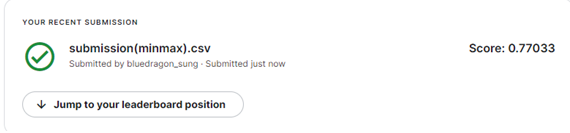

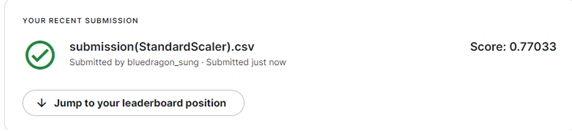

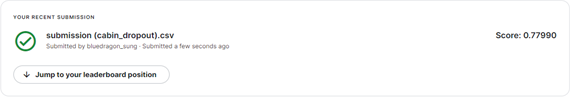